# matrix fold of gate X

In [2]:
# Checking the version of PYTHON; we only support > 3.5
import sys
sys.path.append('../../../Transferências/qiskit-sdk-py-master')

if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')

import qiskit
import numpy

# Import the QISKit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram, Result
from qiskit import available_backends, execute, register, get_backend
import getpass, time
import Qconfig
from qiskit import compile


# import basic plot tools
from qiskit.tools.visualization import plot_histogram, circuit_drawer, plot_state

#information of API
from IBMQuantumExperience import IBMQuantumExperience

# Import tomography tools
import qiskit.tools.qcvv.tomography as tomo

# Aditional packages
from qiskit.tools.qi.qi import *

In [3]:
api = IBMQuantumExperience(Qconfig.APItoken)
myCredits = api.get_my_credits()

print(myCredits)

# set the APIToken and API url
try:
    register(Qconfig.APItoken,Qconfig.config['url'])

    print('\nYou have access to great power!')
    print(available_backends({'local': False, 'simulator': False}))
    print('Available simulators:')
    print(available_backends({'simulator':True}))
except: 
    print('Something went wrong.\nDid you enter a correct token?')

{'promotional': 0, 'remaining': 15, 'maxUserType': 15}

You have access to great power!
['ibmq_16_rueschlikon', 'ibmq_5_tenerife', 'ibmq_5_yorktown']
Available simulators:
['ibmq_qasm_simulator', 'local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']


In [4]:
# Creating Programs
# create QuantumProgram object instance.
qp = QuantumProgram()

# Creating Registers
# create Quantum Register called "qr" with 3 qubits 
qr = qp.create_quantum_register('qr', 3)
# create Classical Register  called "cr" with 3 bits
cr = qp.create_classical_register('cr', 3)

# Creating Circuits
# create Quantum Circuit called "qc" involving your Quantum Register "qr"
# and your Classical Register "cr"
qc = qp.create_circuit('Circuit', [qr], [cr])

In [5]:
# Get the components.

# get the circuit by Name
circuit = qp.get_circuit('Circuit')

# get the Quantum Register by Name
quantum_r = qp.get_quantum_register('qr')

# get the Classical Register by Name
classical_r = qp.get_classical_register('cr')

In [6]:
# preparing qubits

# the circuit we want:
qc.ccx(qr[0],qr[1],qr[2])
qc.x(qr[0])
qc.ccx(qr[0],qr[1],qr[2])
qc.x(qr[0])

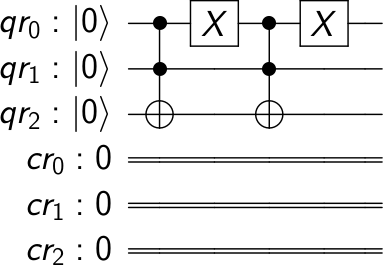

In [7]:
circuit_drawer(qc)

In [8]:
job = execute(qc, backend='local_unitary_simulator')
np.round(job.result().get_data(qc)['unitary'], 3)

array([[ 1.-0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -0.-0.j,  0.+0.j,
         0.+0.j],
       [-0.+0.j,  1.-0.j,  0.+0.j,  0.+0.j,  0.-0.j, -0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  1.-0.j,
         0.-0.j],
       [ 0.+0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,
         1.-0.j],
       [ 0.+0.j, -0.-0.j,  0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  1.-0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j,  0.+0.j,  0.+0.j, -0.+0.j,
        -0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j,  1.-0.j,  0.+0.j,  0.+0.j,  0.-0.j,
        -0.+0.j]])

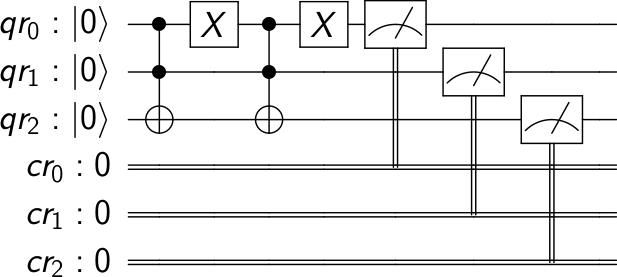

In [9]:
qc.measure(qr[0], cr[0])
qc.measure(qr[1], cr[1])
qc.measure(qr[2], cr[2])

circuit_drawer(qc)

In [10]:
qp.get_circuit_names()

['Circuit']

In [11]:
# QASM from a program

QASM_source = qp.get_qasm('Circuit')

print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[3];
creg cr[3];
ccx qr[0],qr[1],qr[2];
x qr[0];
ccx qr[0],qr[1],qr[2];
x qr[0];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];



In [12]:
backend = 'local_qasm_simulator' 
circuits = ['Circuit']  # Group of circuits to execute

In [13]:
qobj=qp.compile(circuits, backend) # Compile program

In [14]:
result = qp.run(qobj, timeout=240) #run program
print(result)

COMPLETED


In [15]:
result.get_counts('Circuit')

{'000': 1024}

Status @ 0 seconds
{'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': None}
{'status': <JobStatus.DONE: 'job has successfully run'>, 'status_msg': None}
{'000': 1024}


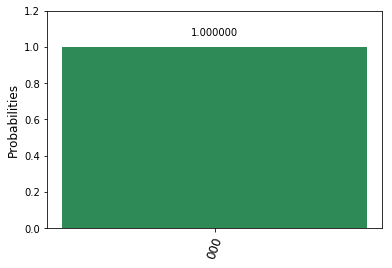

In [16]:
#other way complire and run:
job = execute(qc, backend='local_qasm_simulator', shots=1024, max_credits=3)

lapse = 0
interval = 5
while not job.done:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status)
    time.sleep(interval)
    lapse += 1
print(job.status)

print(job.result().get_counts(qc))
plot_histogram(job.result().get_counts(qc))

In [1]:
#the circuit running is not the one we write
qobj = compile(qc, backend='local_qasm_simulator')

qasm_str = qp.get_compiled_qasm(qobj, 'Circuit')

qasm_circ = qiskit.load_qasm_string(qasm_str);
circuit_drawer(qasm_circ)

NameError: name 'qc' is not defined

In [18]:
print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[3];
creg cr[3];
h qr[2];
cx qr[1],qr[2];
tdg qr[2];
cx qr[0],qr[2];
t qr[2];
cx qr[1],qr[2];
t qr[1];
tdg qr[2];
cx qr[0],qr[2];
cx qr[0],qr[1];
tdg qr[1];
t qr[0];
cx qr[0],qr[1];
x qr[0];
t qr[2];
h qr[2];
h qr[2];
cx qr[1],qr[2];
tdg qr[2];
cx qr[0],qr[2];
t qr[2];
cx qr[1],qr[2];
t qr[1];
tdg qr[2];
cx qr[0],qr[2];
cx qr[0],qr[1];
tdg qr[1];
t qr[0];
cx qr[0],qr[1];
x qr[0];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
t qr[2];
h qr[2];
measure qr[2] -> cr[2];



# Running on a real device


In [19]:
def lowest_pending_jobs():
    """Returns the backend with lowest pending jobs."""
    list_of_backends = available_backends(
        {'local': False, 'simulator': False})
    device_status = [get_backend(backend).status
                     for backend in list_of_backends]

    best = min([x for x in device_status if x['operational'] is True],
               key=lambda x: x['pending_jobs'])
    return best['name']

backend = lowest_pending_jobs()
print("The best backend is " + backend)

The best backend is ibmqx4


In [20]:
api.backend_status(backend)

{'available': True, 'backend': 'ibmqx4', 'pending_jobs': 5}

In [21]:
api.backend_calibration(backend)

{'backend': 'ibmqx4',
 'lastUpdateDate': '2018-07-31T09:56:43.000Z',
 'multiQubitGates': [{'gateError': {'date': '2018-07-31T09:56:43Z',
    'value': 0.030172186236362503},
   'name': 'CX1_0',
   'qubits': [1, 0],
   'type': 'CX'},
  {'gateError': {'date': '2018-07-31T09:56:43Z',
    'value': 0.022706065613666004},
   'name': 'CX2_0',
   'qubits': [2, 0],
   'type': 'CX'},
  {'gateError': {'date': '2018-07-31T09:56:43Z', 'value': 0.04570350848648097},
   'name': 'CX2_1',
   'qubits': [2, 1],
   'type': 'CX'},
  {'gateError': {'date': '2018-07-31T09:56:43Z', 'value': 0.07328729043000415},
   'name': 'CX3_2',
   'qubits': [3, 2],
   'type': 'CX'},
  {'gateError': {'date': '2018-07-31T09:56:43Z',
    'value': 0.041993419696321255},
   'name': 'CX3_4',
   'qubits': [3, 4],
   'type': 'CX'},
  {'gateError': {'date': '2018-07-31T09:56:43Z', 'value': 0.05004433614140752},
   'name': 'CX4_2',
   'qubits': [4, 2],
   'type': 'CX'}],
 'qubits': [{'gateError': {'date': '2018-07-31T09:56:43Z',
   

In [22]:
api.backend_parameters(backend)

{'backend': 'ibmqx4',
 'fridgeParameters': {'Temperature': {'date': '-', 'unit': '-', 'value': []},
  'cooldownDate': '2017-09-07'},
 'lastUpdateDate': '2018-07-31T09:56:43.000Z',
 'qubits': [{'T1': {'date': '2018-07-31T09:56:43Z',
    'unit': 'µs',
    'value': 50.4},
   'T2': {'date': '2018-07-31T09:56:43Z', 'unit': 'µs', 'value': 55.5},
   'buffer': {'date': '2018-07-31T09:56:43Z', 'unit': 'ns', 'value': 10},
   'frequency': {'date': '2018-07-31T09:56:43Z',
    'unit': 'GHz',
    'value': 5.24985},
   'gateTime': {'date': '2018-07-31T09:56:43Z', 'unit': 'ns', 'value': 60},
   'name': 'Q0'},
  {'T1': {'date': '2018-07-31T09:56:43Z', 'unit': 'µs', 'value': 52.4},
   'T2': {'date': '2018-07-31T09:56:43Z', 'unit': 'µs', 'value': 22.9},
   'buffer': {'date': '2018-07-31T09:56:43Z', 'unit': 'ns', 'value': 10},
   'frequency': {'date': '2018-07-31T09:56:43Z',
    'unit': 'GHz',
    'value': 5.29575},
   'gateTime': {'date': '2018-07-31T09:56:43Z', 'unit': 'ns', 'value': 60},
   'name': 'Q1

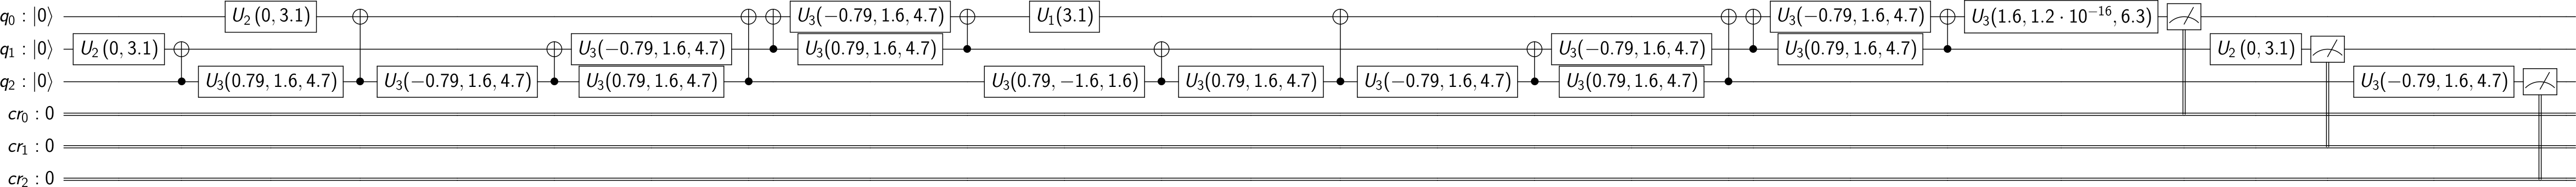

In [23]:
qobj = compile(qc, backend=backend)

qs_str = qp.get_compiled_qasm(qobj, 'Circuit')

qs_circ = qiskit.load_qasm_string(qs_str);
circuit_drawer(qs_circ)


In [24]:
print(qs_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg cr[3];
u2(0,3.14159265358979) q[1];
cx q[2],q[1];
u3(0.785398163397448,1.57079632679490,4.71238898038469) q[2];
u2(0,3.14159265358979) q[0];
cx q[2],q[0];
u3(-0.785398163397448,1.57079632679490,4.71238898038469) q[2];
cx q[2],q[1];
u3(-0.785398163397448,1.57079632679490,4.71238898038469) q[1];
u3(0.785398163397448,1.57079632679490,4.71238898038469) q[2];
cx q[2],q[0];
cx q[1],q[0];
u3(-0.785398163397448,1.57079632679490,4.71238898038469) q[0];
u3(0.785398163397448,1.57079632679490,4.71238898038469) q[1];
cx q[1],q[0];
u1(3.14159265358979) q[0];
u3(0.785398163397448,-1.57079632679490,1.57079632679490) q[2];
cx q[2],q[1];
u3(0.785398163397448,1.57079632679490,4.71238898038469) q[2];
cx q[2],q[0];
u3(-0.785398163397448,1.57079632679490,4.71238898038469) q[2];
cx q[2],q[1];
u3(-0.785398163397448,1.57079632679490,4.71238898038469) q[1];
u3(0.785398163397448,1.57079632679490,4.71238898038469) q[2];
cx q[2],q[0];
cx q[1],q[0];
u3(-0.78539816

In [25]:
shots=1024
max_credits=3
job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)

lapse = 0
interval = 10
while not job_exp.done:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job_exp.status)
    time.sleep(interval)
    lapse += 1
print(job_exp.status)

Status @ 0 seconds
{'job_id': None, 'status': <JobStatus.INITIALIZING: 'job is being initialized'>, 'status_msg': 'Job is initializing. Please, wait a moment.'}
Status @ 10 seconds
{'job_id': None, 'status': <JobStatus.INITIALIZING: 'job is being initialized'>, 'status_msg': 'Job is initializing. Please, wait a moment.'}
Status @ 20 seconds
{'job_id': '5b60c0b0a98e23003a62274a', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 5}
Status @ 30 seconds
{'job_id': '5b60c0b0a98e23003a62274a', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 5}
Status @ 40 seconds
{'job_id': '5b60c0b0a98e23003a62274a', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 5}
Status @ 50 seconds
{'job_id': '5b60c0b0a98e23003a62274a', 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': 'job is queued', 'queue_position': 4}
Status @ 60 seconds
{'job_id': '5b60c0b0a98e2

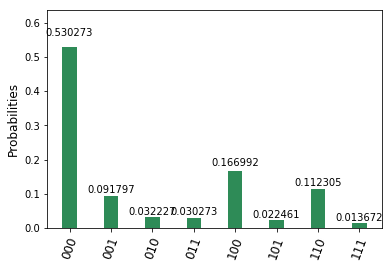

In [26]:
plot_histogram(job_exp.result().get_counts(qc))

In [27]:
job_exp.result().get_data('Circuit')

{'counts': {'000': 543,
  '001': 94,
  '010': 33,
  '011': 31,
  '100': 171,
  '101': 23,
  '110': 115,
  '111': 14},
 'date': '2018-07-31T20:09:24.719Z',
 'time': 24.10594916343689}